In [1]:
import numpy as np
import matplotlib.pyplot as plt
from picca import constants as picca_constants
from scipy import constants as scipy_constants

In [2]:
# MW21 cosmology values
hubble, z = 0.71, 2.5
omegab, omegam = 0.046, 0.27
omegal = 1 - omegam
ns = 0.96

# f(Nhi, X)

In [3]:
def f_Nhi(colden, k, b):
    y = k*(colden**b)
    return y

Their description of f_Nhi is a broken potential function, with one segment for 19 < logNhi < 20.3 cm^-2 and the other 20.3 < logNhi < 22 cm^-2 
The parameters b1 and b2 are given in the paper. k1 and k2 are determinated so that:
- the integration of f_nhi from logNhi=19 to logNhi=20.3 (cm^-2) is 0.1
- f_Nhi(k1, b1) = f_Nhi(k2, b2) at logNhi = 20.3

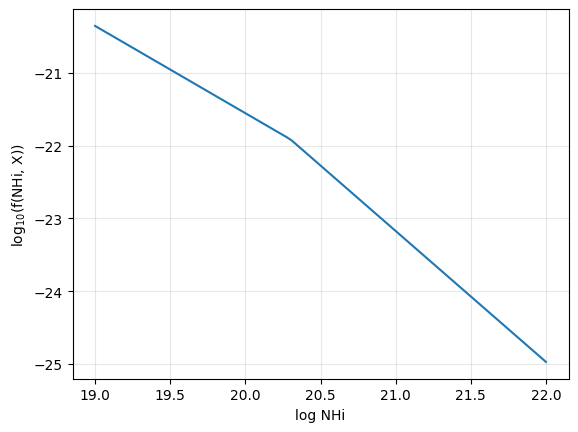

In [4]:
k1, b1 = 280.14, -1.2
k2, b2 = 4.24e14, -1.8

NHirange_mw11 = np.logspace(np.log10(19), np.log10(22), 100)
colden1, colden2 = NHirange_mw11[NHirange_mw11 < 20.3], NHirange_mw11[NHirange_mw11 >= 20.3]
fnhi_mw11 = np.concatenate([f_Nhi(10**colden1, k1, b1), f_Nhi(10**colden2, k2, b2)])

plt.plot(NHirange_mw11, np.log10(fnhi_mw11))
plt.xlabel('log NHi')
plt.ylabel(r'log$_{10}$(f(NHi, X))')
plt.grid(alpha=0.3);

With this f_Nhi we can define the column density distribution function as:

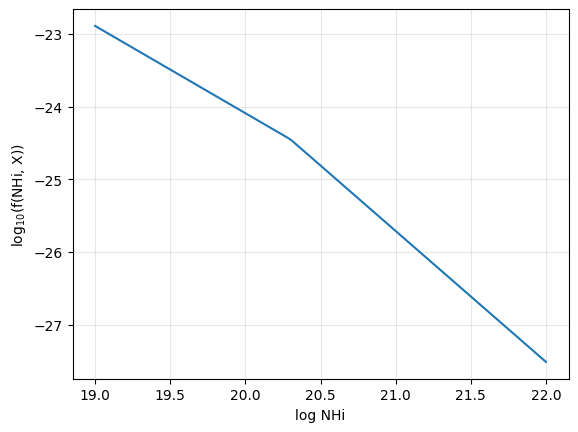

In [5]:
c_kms = scipy_constants.speed_of_light*1e-3  # kms^-1
cddf_mw11 = fnhi_mw11*100*hubble*((1+z)**2)/c_kms

plt.plot(NHirange_mw11, np.log10(cddf_mw11))
plt.xlabel('log NHi')
plt.ylabel(r'log$_{10}$(f(NHi, X))')
plt.grid(alpha=0.3);

# Voigt profile

In [6]:
from w1_w2 import wave_to_fft_profile

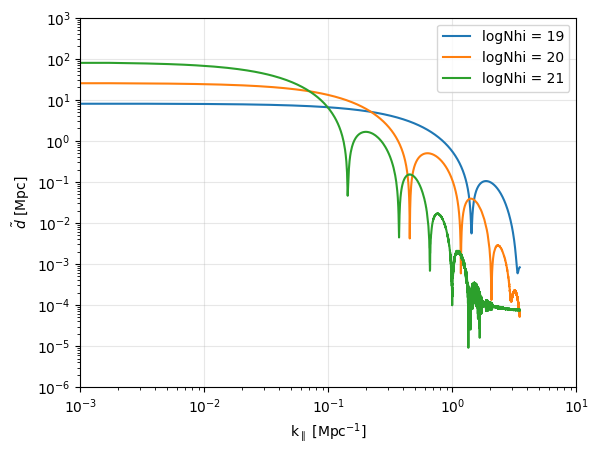

In [7]:
wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

NHirange = [19, 20, 21]

for i, nhi_value in enumerate(NHirange):
    k_w1w2, d, Deltax = wave_to_fft_profile(wave, z, nhi_value, omegam=omegam, omegal=omegal, hubble=hubble)
    plt.plot(k_w1w2, d, label='logNhi = %.0f' %nhi_value)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1e-3, 1e1)
    plt.ylim(1e-6, 1e3)
    plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
    plt.ylabel(r'$\tilde{d}$ [Mpc]')
    plt.grid(alpha=0.3)
    plt.legend();

# Absorption profile MW11

In [8]:
from astropy.cosmology import FlatLambdaCDM
cosmo_astropy = FlatLambdaCDM(H0=hubble*100, Om0=omegam, Ob0=omegab)

In [9]:
from w1_w2 import fft_profile

In [10]:
wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

lambda_lya = picca_constants.ABSORBER_IGM["LYA"]
z_value = wave/lambda_lya - 1
xi = np.array(cosmo_astropy.comoving_distance(z_value))  # Mpc 
xi_lin = np.linspace(xi.min(), xi.max(), len(xi))  # We will need this for later
xi0 = np.array(cosmo_astropy.comoving_distance(z))  # Mpc



d(k_los = 0, logNHi = 19) = 3681.79
d(k_los = 0, logNHi = 20) = 3664.70
d(k_los = 0, logNHi = 21) = 3610.99


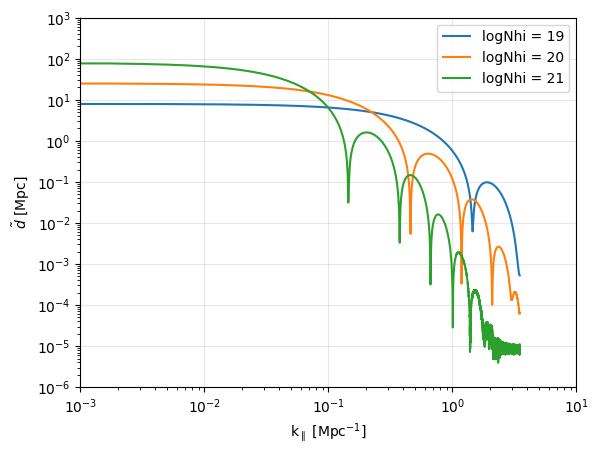

In [11]:
NHirange = [19, 20, 21]
kappa2 = 5e-19

for nhi_value in NHirange:
    y = np.exp(-((10**nhi_value)*kappa2/((xi-xi0)**2)))
    # We need y to be linearly spaced for the fft
    y_lin = np.interp(xi_lin, xi, y)
    k_mw11, d_mw11 = fft_profile(1-y_lin, dx=xi_lin[1]-xi_lin[0])
    plt.plot(k_mw11, d_mw11, label='logNhi = %.0f' %nhi_value)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(1e-3, 1e1)
    plt.ylim(1e-6, 1e3)
    plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
    plt.ylabel(r'$\tilde{d}$ [Mpc]')
    plt.grid(alpha=0.3)
    plt.legend()
    print('d(k_los = 0, logNHi = %.0f) = %.2f' %(nhi_value, d_mw11[0]))

# Equivalent width

## Voigt profile

In [12]:
from w1_w2 import get_voigt_profile_wave, profile_wave_to_comov_dist

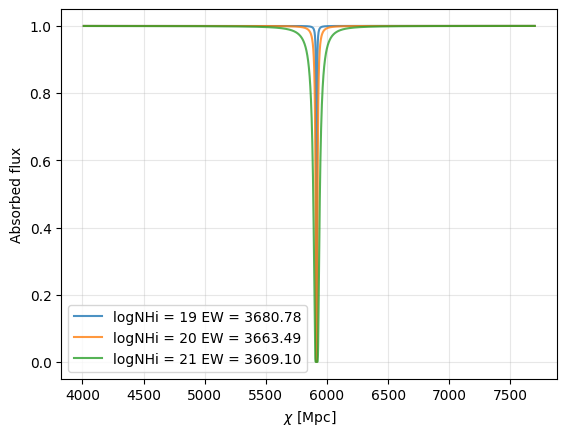

In [13]:
wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

NHirange = [19, 20, 21]

for i, nhi_value in enumerate(NHirange):
    flux_wavelength = get_voigt_profile_wave(wave, z, nhi_value)
    comov, flux_voigt = profile_wave_to_comov_dist(wave, flux_wavelength, omegam, hubble)
    ew_voigt = np.trapezoid(flux_voigt, comov)
    plt.plot(comov, flux_voigt, alpha=0.8, label='logNHi = %.0f EW = %.2f' %(nhi_value, ew_voigt))
    plt.xlabel(r'$\chi$ [Mpc]')
    plt.ylabel(r'Absorbed flux')
    plt.grid(alpha=0.3)
    plt.legend();
    

## MW11 model

In [14]:
from astropy.cosmology import FlatLambdaCDM
cosmo_astropy = FlatLambdaCDM(H0=hubble*100, Om0=omegam, Ob0=omegab)

In [15]:
wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

lambda_lya = picca_constants.ABSORBER_IGM["LYA"]
z_value = wave/lambda_lya - 1
xi = np.array(cosmo_astropy.comoving_distance(z_value))  # Mpc
xi_lin = np.linspace(xi.min(), xi.max(), len(xi))  # We will need this for later
xi0 = np.array(cosmo_astropy.comoving_distance(z))  # Mpc

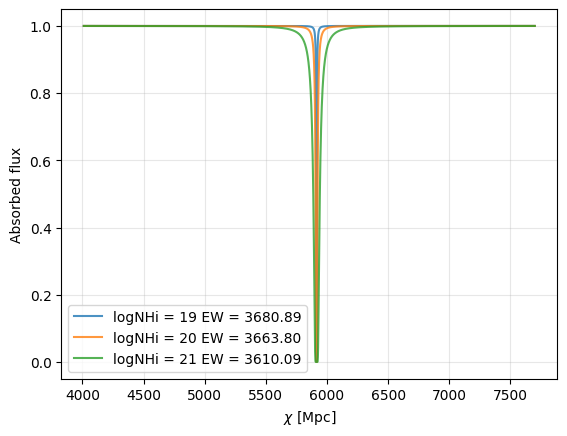

In [16]:
NHirange = [19, 20, 21]
kappa2 = 5e-19

for nhi_value in NHirange:
    y = np.exp(-((10**nhi_value)*kappa2/((xi-xi0)**2)))
    # We need y to be linearly spaced for the fft
    y_lin = np.interp(xi_lin, xi, y)
    ew_mw11 = np.trapezoid(y_lin, xi_lin)
    plt.plot(xi, y, alpha=0.8, label='logNHi = %.0f EW = %.2f' %(nhi_value, ew_mw11))
    plt.xlabel(r'$\chi$ [Mpc]')
    plt.ylabel(r'Absorbed flux')
    plt.grid(alpha=0.3)
    plt.legend();

# w1 and w2

## Voigt model

In [17]:
from w1_w2 import wave_to_fft_profile

wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

d, w2_int, w1_int = [], [], []
for i, nhi_value in enumerate(NHirange_mw11):
    k_voigt, d_voigt, delta_x = wave_to_fft_profile(wave, z, nhi_value, omegam, omegal, hubble)
    d.append(d_voigt)
    w1_int.append(cddf_mw11[i]*(d_voigt**2)*np.log(10)*(10**nhi_value))
    w2_int.append(cddf_mw11[i]*d_voigt*np.log(10)*(10**nhi_value))

d, w2_int, w1_int = np.array(d), np.array(w2_int), np.array(w1_int)
w1_voigt = np.trapezoid(w1_int, NHirange_mw11, axis=0)  # Logarithmic integration
w2_voigt = np.trapezoid(w2_int, NHirange_mw11, axis=0)  # Logarithmic integration

## MW11 model

In [18]:
from astropy.cosmology import FlatLambdaCDM
cosmo_astropy = FlatLambdaCDM(H0=hubble*100, Om0=omegam, Ob0=omegab)
from w1_w2 import fft_profile

wave_log = np.linspace(np.log10(2800), np.log10(6800), 2**12) # Angstrom
wave = 10**wave_log

lambda_lya = picca_constants.ABSORBER_IGM["LYA"]
z_value = wave/lambda_lya - 1
xi = np.array(cosmo_astropy.comoving_distance(z_value))  # Mpc 
xi_lin = np.linspace(xi.min(), xi.max(), len(xi))  # We will need this for later
xi0 = np.array(cosmo_astropy.comoving_distance(z))  # Mpc
kappa2 = 5e-19

d, w2_int, w1_int = [], [], []
for i, nhi_value in enumerate(NHirange_mw11):
    y = np.exp(-((10**nhi_value)*kappa2/((xi-xi0)**2)))
    # We need y to be linearly spaced for the fft
    y_lin = np.interp(xi_lin, xi, y)
    k_mw11, d_mw11 = fft_profile(1-y_lin, dx=xi_lin[1]-xi_lin[0])
    d.append(d_mw11)
    w1_int.append(cddf_mw11[i]*(d_mw11**2)*np.log(10)*(10**nhi_value))
    w2_int.append(cddf_mw11[i]*d_mw11*np.log(10)*(10**nhi_value))

d, w2_int, w1_int = np.array(d), np.array(w2_int), np.array(w1_int)
w1_mw11 = np.trapezoid(w1_int, NHirange_mw11, axis=0)  # Logarithmic integration
w2_mw11 = np.trapezoid(w2_int, NHirange_mw11, axis=0)  # Logarithmic integration

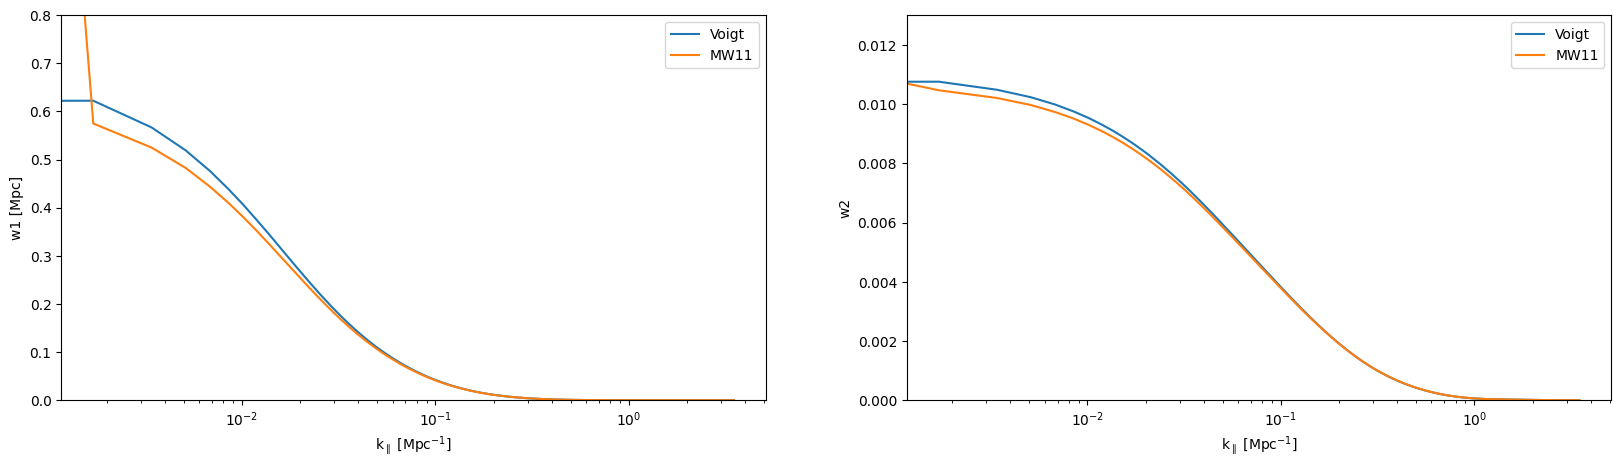

In [23]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 2, 1)
plt.plot(k_voigt, w1_voigt, label='Voigt')
plt.plot(k_mw11, w1_mw11, label='MW11')
plt.ylabel(r'w1 [Mpc]')
plt.xscale('log')
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
plt.ylim(0, 0.8)
plt.legend();

plt.subplot(1, 2, 2)
plt.plot(k_voigt, w2_voigt, label='Voigt')
plt.plot(k_mw11, w2_mw11, label='MW11')
plt.ylabel(r'w2')
plt.xscale('log')
plt.xlabel(r'k$_\parallel$ [Mpc$^{-1}$]')
plt.ylim(0, 0.013)
plt.legend();

In [24]:
print(w2_mw11[0], w2_voigt[0])  # First values are weird?
print(w2_mw11[1], w2_voigt[1])

1.3720185093845678 0.00014671769124702193
0.010466330905550684 0.010755822727372842


Is it the same as when using the equivalent width?

In [25]:
w2_mw11_0 = np.trapezoid(ew_mw11*np.log(10)*(10**NHirange_mw11)*cddf_mw11, NHirange_mw11)
w2_voigt_0 = np.trapezoid(ew_voigt*np.log(10)*(10**NHirange_mw11)*cddf_mw11, NHirange_mw11)
print('Voigt profile - W2(k=0) using EW = ', w2_voigt_0)
print('MW11 profile - W2(k=0) using EW = ', w2_mw11_0)

Voigt profile - W2(k=0) using EW =  1.352480066464841
MW11 profile - W2(k=0) using EW =  1.3528489651960731


So apparently only with the absorption profile detailed in MW11 I can recover what they said: "At small k, W2 becomes equal to the fraction of the continuum that is absorbed by damping wings." Check astrid_hcd overleaf andreu's notes for more explanation.